## Econ 148 Project 3 Figure 1

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bootstrap

In [79]:
# Read in all data
data = pd.read_csv('climate_conflict_replication/clim_conflict_for_R.csv')
ssa = pd.read_csv('climate_conflict_replication/gseasSSA.csv')
area = pd.read_csv('climate_conflict_replication/croparea_weight.csv', encoding="windows-1252")
cltol = pd.read_csv('climate_conflict_replication/precip_climatology.csv', index_col=0)
mss_country = pd.read_csv('climate_conflict_replication/mss_countries_new.csv')
precip = pd.read_csv("climate_conflict_replication/precip_climatology.csv", index_col=0)
mss_country = pd.read_csv("climate_conflict_replication/mss_countries_new.csv", header=0)
mss_country.iloc[:, 0] = mss_country.iloc[:, 0].astype(str)
mss = mss_country.iloc[:, 0].unique().tolist()
scenario_df = np.load('altogether_monthly.npy', allow_pickle=True)

In [93]:
# --- Setup ---
regions = ["Sahel", "West Africa", "Central Africa", "Eastern Africa", "Southern Africa", "Sub-Saharan Africa"]
region_indices = [4, 5, 6, 7, 8]
n_models = 20

In [94]:
# --- Calculate unweighted regional land shares ---
land_area = area[area["element"] == "Area Harvested (Ha)"]
region_land_area = land_area.groupby("region")["2000"].sum()
unweight = region_land_area / region_land_area.sum()
unweight = unweight.values

In [95]:
# --- Calculate climate changes ---
clim = np.zeros((6, 2, n_models))  # (regions, variables, models)

In [96]:
# Temperature: mean change over growing season months
for i, reg_idx in enumerate(region_indices):
    for model in range(n_models):
        clim[i, 0, model] = scenario_df[reg_idx, :, 1, 0, model].mean()

/Users/davidkim/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [97]:
# Precipitation: normalized growing season change
for i, reg_idx in enumerate(region_indices):
    for model in range(n_models):
        ratios = scenario_df[reg_idx, :, 1, 1, model] / 100 + 1
        baseline = cltol.iloc[i, :].values
        changed_sum = np.sum(baseline * ratios)
        baseline_sum = np.sum(baseline)
        clim[i, 1, model] = ((changed_sum / baseline_sum) - 1) * 100

/var/folders/th/hwcvn4v50mzbrl3x2ftngk3w0000gn/T/ipykernel_34159/682649523.py:4: RuntimeWarning: invalid value encountered in divide
  ratios = scenario_df[reg_idx, :, 1, 1, model] / 100 + 1


In [101]:
# Sub-Saharan Africa
clim[5, :, :] = np.tensordot(unweight, clim[:5, :, :], axes=(0, 0))

AttributeError: 'list' object has no attribute 'iloc'

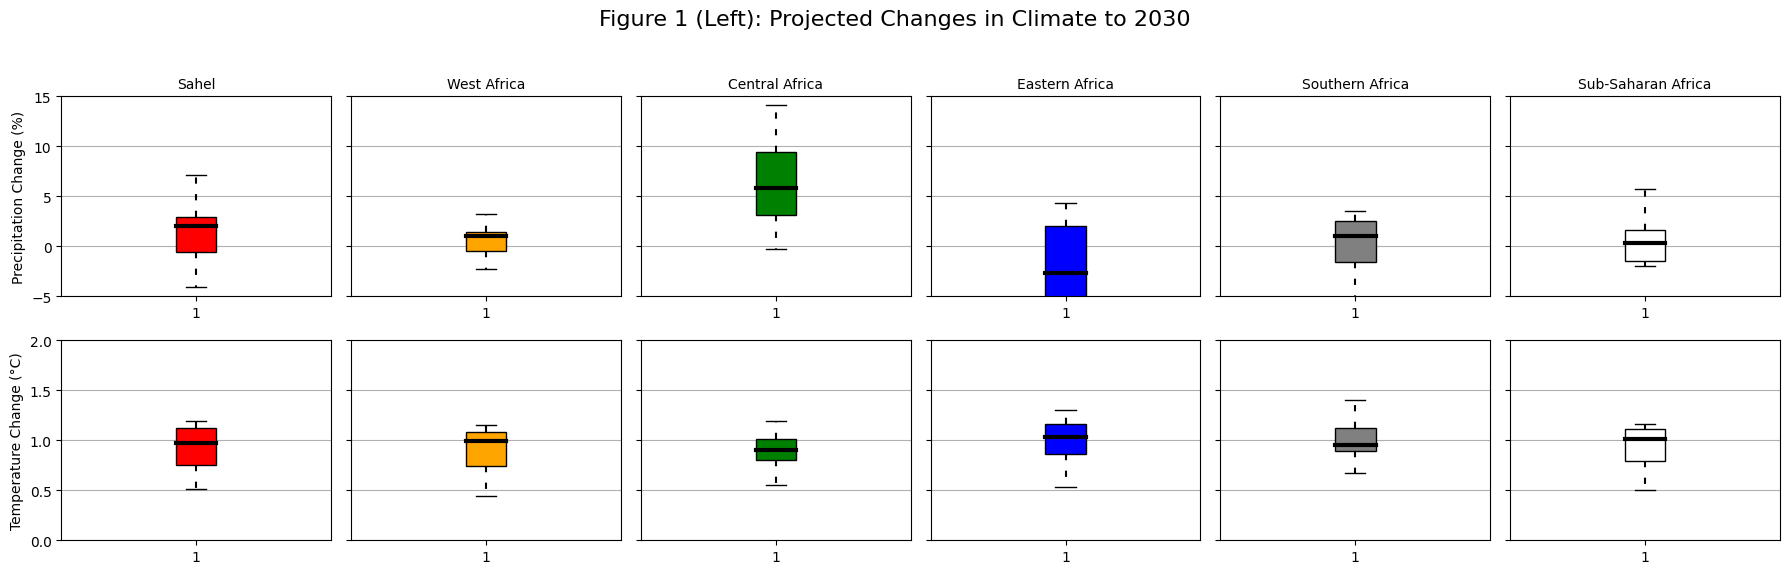

In [121]:
# --- Figure 1 Panel 1 ---
# - Boxplots for projected precipitation change (%) on top row
# - Boxplots for projected temperature change (°C) on bottom row
# - For 5 SSA regions + SSA-wide (6 total)

fig, axes = plt.subplots(2, 6, figsize=(18, 6), sharey='row')
regions = ["Sahel", "West Africa", "Central Africa", "Eastern Africa", "Southern Africa", "Sub-Saharan Africa"]
colors = ['red', 'orange', 'green', 'blue', 'grey', 'white']

# Top row: Precipitation Change (%)
for i, region in enumerate(regions):
    precip_clean = clim[i, 1, :]
    precip_clean = precip_clean[~np.isnan(precip_clean)]
    axes[0, i].boxplot(precip_clean, 
                       patch_artist=True, 
                       boxprops=dict(facecolor=colors[i]), 
                       showfliers=False, 
                       medianprops=dict(color="black", linewidth=3), 
                       whiskerprops=dict(linestyle=(0, (3, 5)), color="black", linewidth=1.5))
    axes[0, i].set_title(region, fontsize=10)
    axes[0, i].set_ylim([-5, 15])
    if i == 0:
        axes[0, i].set_ylabel("Precipitation Change (%)")
    axes[0, i].grid(True, axis='y')

# Bottom row: Temperature Change (°C)
for i, region in enumerate(regions):
    temp_clean = clim[i, 0, :]
    temp_clean = temp_clean[~np.isnan(temp_clean)]
    axes[1, i].boxplot(temp_clean, 
                       patch_artist=True, 
                       boxprops=dict(facecolor=colors[i]), 
                       showfliers=False, 
                       medianprops=dict(color="black", linewidth=3),
                       whiskerprops=dict(linestyle=(0, (3, 5)), color="black", linewidth=1.5))
    axes[1, i].set_ylim([0, 2])
    if i == 0:
        axes[1, i].set_ylabel("Temperature Change (°C)")
    axes[1, i].grid(True, axis='y')

plt.suptitle("Figure 1 (Left): Projected Changes in Climate to 2030", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


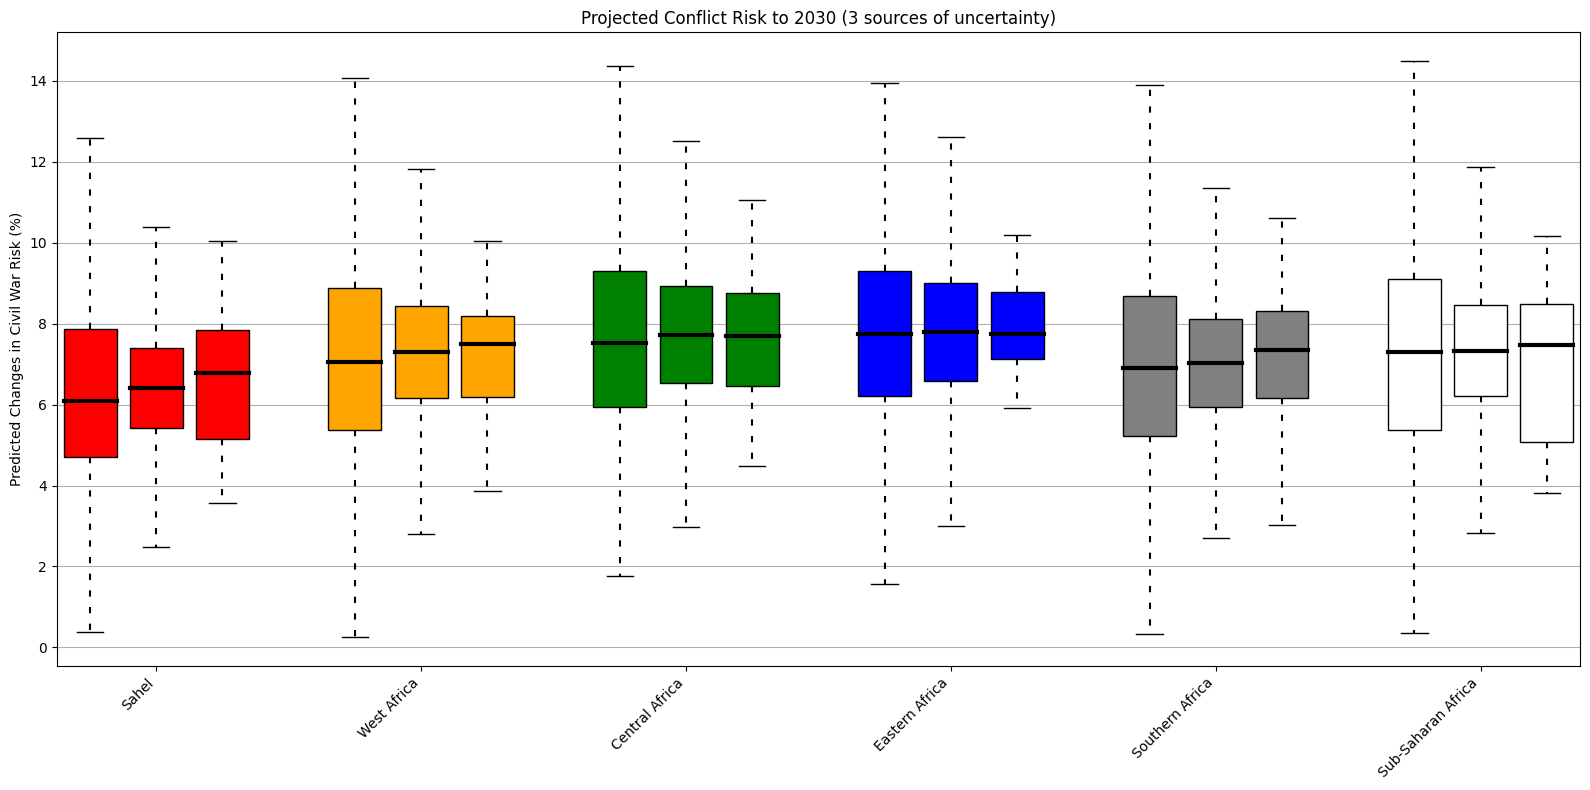

In [124]:
# --- Figure 1 Panel 2 ---

# Simulated OLS estimates for temp_all and temp_all_lag from Model 1
coefs_mean = np.array([0.0480, 0.0138])

# Simulated bootstrap coefficient samples
n_bootstrap = 10000
coefs_boot = np.random.normal(loc=coefs_mean, scale=[0.01, 0.01], size=(n_bootstrap, 2))

# Simulated temp projections per region (6 regions x 20 models)
temp_proj_models = np.random.normal(loc=1.2, scale=0.3, size=(6, 20))

# --- Simulate all 3 boxplot scenarios ---
regions = ["Sahel", "West Africa", "Central Africa", "Eastern Africa", "Southern Africa", "Sub-Saharan Africa"]
colors = ['red', 'orange', 'green', 'blue', 'grey', 'white']

# Storage: per region
conflict_preds_full = []   # Full uncertainty
conflict_preds_conflict_only = []  # Conflict model uncertainty only
conflict_preds_climate_only = []   # Climate model uncertainty only

# For each region
for i in range(6):
    temp_proj = temp_proj_models[i, :]
    temp_proj = temp_proj[~np.isnan(temp_proj)]  # Clean NaN if any
    
    # Boxplot 1: Full uncertainty (sample both coefs and temps)
    preds_full = []
    for _ in range(n_bootstrap):
        coef = coefs_boot[np.random.choice(range(n_bootstrap))]
        temp = np.random.choice(temp_proj)
        pred = 100 * (coef[0] * temp + coef[1] * temp)
        preds_full.append(pred)
    conflict_preds_full.append(preds_full)
    
    # Boxplot 2: Conflict model uncertainty only (fixed temp)
    temp_mean = np.mean(temp_proj)
    preds_conflict = []
    for coef in coefs_boot:
        pred = 100 * (coef[0] * temp_mean + coef[1] * temp_mean)
        preds_conflict.append(pred)
    conflict_preds_conflict_only.append(preds_conflict)
    
    # Boxplot 3: Climate model uncertainty only (fixed coefs)
    preds_climate = []
    for temp in temp_proj:
        pred = 100 * (coefs_mean[0] * temp + coefs_mean[1] * temp)
        preds_climate.append(pred)
    preds_climate = np.random.choice(preds_climate, size=n_bootstrap, replace=True)
    conflict_preds_climate_only.append(preds_climate)

# --- Plot all 3 boxplots per region ---
fig, ax = plt.subplots(figsize=(16, 8))

positions = []
labels = []
data = []

# Collect data for grouped plotting
for i, region in enumerate(regions):
    base = i * 4
    positions.extend([base, base+1, base+2])
    labels.extend([region + " (full)", region + " (conflict)", region + " (climate)"])
    data.extend([
        conflict_preds_full[i],
        conflict_preds_conflict_only[i],
        conflict_preds_climate_only[i]
    ])

# Make boxplots
box = ax.boxplot(data, 
                 positions=positions, 
                 widths=0.8, 
                 patch_artist=True, 
                 showfliers= False, 
                 medianprops=dict(color="black", linewidth=3),
                 whiskerprops=dict(linestyle=(0, (3, 5)), color="black", linewidth=1.5))

# Color coding
for patch, color_idx in zip(box['boxes'], np.repeat(range(6), 3)):
    patch.set_facecolor(colors[color_idx])

ax.set_ylim(-5, 15)

ax.set_xticks([i * 4 + 1 for i in range(6)])
ax.set_xticklabels(regions, rotation=45, ha="right")
ax.set_ylabel("Predicted Changes in Civil War Risk (%)")
ax.set_title("Projected Conflict Risk to 2030 (3 sources of uncertainty)")
ax.grid(axis='y')

plt.tight_layout()
plt.show()
